In [ ]:
import time
import torch
import sys
sys.path.append('LLaVA')
sys.path.append('C:\\transf\\XAI_DEEPFAKE\\LLaVA')

import pandas as pd
from PIL import Image
import numpy as np
import cv2
from torch.nn.functional import cosine_similarity
from pathlib import Path
import json
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model_frame
from tqdm import tqdm
import clip
import warnings
import os
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MaskUtils:
    @staticmethod
    def apply_mask(frame, keypoint, use_hard_mask=True, radius=75):
        h, w, c = frame.shape
        kp_x = keypoint["x"] * w
        kp_y = keypoint["y"] * h
        yy, xx = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
        distance = np.sqrt((xx - kp_x)**2 + (yy - kp_y)**2)
        mask = (distance <= radius).astype(np.uint8)
        if use_hard_mask:
            for ch in range(c):
                frame[:, :, ch] = frame[:, :, ch] * mask
        else:
            blur_ksize = 83
            dilation_iter = 1
            mask = mask.astype(np.float32)
            blurred = cv2.GaussianBlur(mask, (blur_ksize, blur_ksize), 83)
            blurred_normalized = cv2.normalize(blurred, None, 0, 1, cv2.NORM_MINMAX)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
            dilated = cv2.dilate(blurred_normalized, kernel, iterations=dilation_iter)
            for ch in range(c):
                frame[:, :, ch] = frame[:, :, ch].astype(np.float32) * dilated
            frame = frame.astype(np.uint8)
        return frame

def safe_load_model(model_path, max_retries=3, delay=5):
    attempt = 0
    while attempt < max_retries:
        try:
            tokenizer, llava_model, image_processor, context_len = load_pretrained_model(
                model_path=model_path,
                model_base=None,
                model_name=get_model_name_from_path(model_path)
            )
            return tokenizer, llava_model, image_processor, context_len
        except ZeroDivisionError:
            print(f"ZeroDivisionError during model loading. Retrying... (Attempt {attempt + 1})")
            time.sleep(delay)
            attempt += 1
    raise RuntimeError("Failed to load the model after multiple attempts")

def get_clip_embedding(image, layer="last"):
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    image_tensor = image_tensor.half() if clip_model.visual.conv1.weight.dtype == torch.half else image_tensor
    with torch.no_grad():
        if layer == "first":
            x = clip_model.visual.conv1(image_tensor)
            x = clip_model.visual.bn1(x)
            x = clip_model.visual.relu1(x)
            x = clip_model.visual.conv2(x)
            x = clip_model.visual.bn2(x)
            x = clip_model.visual.relu2(x)
            x = clip_model.visual.conv3(x)
            x = clip_model.visual.bn3(x)
            x = clip_model.visual.relu3(x)
            x = clip_model.visual.avgpool(x)
            embedding = x
        elif layer == "middle":
            x = clip_model.visual.conv1(image_tensor)
            x = clip_model.visual.bn1(x)
            x = clip_model.visual.relu1(x)
            x = clip_model.visual.conv2(x)
            x = clip_model.visual.bn2(x)
            x = clip_model.visual.relu2(x)
            x = clip_model.visual.conv3(x)
            x = clip_model.visual.bn3(x)
            x = clip_model.visual.relu3(x)
            x = clip_model.visual.avgpool(x)
            x = clip_model.visual.layer1(x)
            x = clip_model.visual.layer2(x)
            x = clip_model.visual.layer3(x)
            embedding = x
        elif layer == "last":
            embedding = clip_model.encode_image(image_tensor)
        else:
            raise ValueError("Invalid layer specified. Choose from 'first', 'middle', or 'last'.")
        embedding = embedding.view(embedding.size(0), -1)
    return embedding

def create_custom_prompt(annotations, prompt_version=1):
    if prompt_version == 1:
        base_prompt = (
            "Based on the following descriptions: {annotations}, analyze the face in the image and "
            "identify any signs of deepfake artifacts. Consider how the descriptions might relate to "
            "potential manipulations. Look for abnormalities such as inconsistent lighting, unnatural "
            "facial movements, blurriness around the edges, strange reflections in the eyes, mismatched "
            "facial features, or any other indications of digital manipulation. Provide a detailed "
            "description of any anomalies found."
        )
    if prompt_version == 2:
        base_prompt = (
            "Analyze the face in the image based on the description: '{annotations}'. Identify any "
            "deepfake artifacts, focusing specifically on the affected parts of the face mentioned. "
            "Provide a short and direct explanation highlighting the inconsistencies or manipulations."
        )
    if prompt_version == 3:
        base_prompt = (
            "Based on the following annotations: {annotations}, examine the face in the image for any signs of deepfake manipulation. "
            "Note that the annotations highlight possible alterations, but there may be additional anomalies not captured by them. "
            "Provide a concise and objective analysis identifying any inconsistencies, artifacts, or unusual features that could indicate digital manipulation."
        )
    return base_prompt.format(annotations=', '.join(f'"{ann}"' for ann in annotations))

def detect_deepfake(frame, custom_prompt):
    if isinstance(frame, np.ndarray):
        frame = frame.astype('uint8')
    else:
        raise ValueError("Invalid frame data. Expected a NumPy array.")
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(frame_rgb)
    local_args = type('Args', (), {
        "model_path": model_path,
        "model_base": None,
        "model_name": get_model_name_from_path(model_path),
        "query": custom_prompt,
        "conv_mode": None,
        "temperature": 0,
        "top_p": None,
        "num_beams": 1,
        "max_new_tokens": 512,
    })()
    predicted_sentence = eval_model_frame(
        local_args,
        image_pil,
        tokenizer=tokenizer,
        model=llava_model,
        image_processor=image_processor
    )
    return predicted_sentence

def get_training_frames(df):
    training_frames = {}
    for idx, row in df.iterrows():
        video_name = row['movie_name']
        manipulation_path = Path('C:/transf/XAI_DEEPFAKE/LLaVA') / row['manipulation']
        video_path = (manipulation_path / video_name).resolve()
        click_locations = row['click_locations']
        if not click_locations or pd.isna(click_locations):
            continue
        try:
            frame_data = json.loads(click_locations)
            for frame_str, _ in frame_data.items():
                if frame_str.isdigit():
                    frame_num = int(frame_str) - 1
                    if video_path not in training_frames:
                        training_frames[video_path] = []
                    training_frames[video_path].append((frame_num, row['text']))
        except:
            continue
    for video_path, frames in training_frames.items():
        training_frames[video_path] = sorted(frames, key=lambda x: x[0])
    return training_frames

def get_validation_frames(df, num_files=0):
    frames_dict = {}
    total_rows = len(df)
    if num_files > 0:
        total_rows = min(total_rows, num_files)
    for idx, row in df.iterrows():
        if num_files > 0 and idx >= num_files:
            break
        video_name = row['movie_name']
        manipulation_path = Path('C:/transf/XAI_DEEPFAKE/LLaVA') / row['manipulation']
        video_path = (manipulation_path / video_name).resolve()
        click_locations = row['click_locations']
        if not click_locations or pd.isna(click_locations):
            continue
        try:
            frame_data = json.loads(click_locations)
            if video_path not in frames_dict:
                frames_dict[video_path] = {}
            for frame_str, kpt_info in frame_data.items():
                if frame_str.isdigit():
                    frame_num = int(frame_str) - 1
                    if frame_num not in frames_dict[video_path]:
                        frames_dict[video_path][frame_num] = []
                    if isinstance(kpt_info, dict):
                        frames_dict[video_path][frame_num].append(kpt_info)
                    elif isinstance(kpt_info, list):
                        frames_dict[video_path][frame_num].extend(kpt_info)
        except:
            continue
    final_frames = {}
    for video_path, frame_map in frames_dict.items():
        final_frames[video_path] = sorted(
            [(fnum, kpts) for fnum, kpts in frame_map.items()],
            key=lambda x: x[0]
        )
    return final_frames

def run_pipeline(rn_model_name, extraction_layer, top_k, num_files=0, mask_on=False, use_hard_mask=True, prompt_version=1):
    global clip_model, preprocess
    print(f"\nLoading CLIP model {rn_model_name} on {device} ...")
    clip_model, preprocess = clip.load(rn_model_name, device=device)
    clip_model.eval()

    train_frames = get_training_frames(train_df)
    val_frames = get_validation_frames(val_df, num_files)

    emb_save_path = f"training_embeddings_{rn_model_name}_{extraction_layer}.pt"
    if os.path.exists(emb_save_path):
        print(f"Loading cached training embeddings from {emb_save_path} ...")
        emb_data = torch.load(emb_save_path)
        training_embeddings_tensor = emb_data['embeddings']
        training_annotations = emb_data['annotations']
        training_keys = emb_data['keys']
    else:
        print(f"Computing training embeddings for [{rn_model_name}, {extraction_layer}] ...")
        training_embeddings_list = []
        training_annotations = []
        training_keys = []
        for video_path, frames in tqdm(train_frames.items(), desc=f"Processing training videos [{rn_model_name}, {extraction_layer}]"):
            cap = cv2.VideoCapture(str(video_path))
            if not cap.isOpened():
                continue
            for (frame_number, annotation) in frames:
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
                ret, frame = cap.read()
                if not ret:
                    continue
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image_pil = Image.fromarray(frame_rgb)
                embedding = get_clip_embedding(image_pil, layer=extraction_layer)
                training_embeddings_list.append(embedding)
                training_annotations.append(annotation)
                training_keys.append((video_path, frame_number))
            cap.release()
        if len(training_embeddings_list) == 0:
            raise RuntimeError("No training embeddings computed.")
        training_embeddings_tensor = torch.cat(training_embeddings_list, dim=0)
        torch.save({
            'embeddings': training_embeddings_tensor,
            'annotations': training_annotations,
            'keys': training_keys
        }, emb_save_path)
        print(f"Saved training embeddings to {emb_save_path}")

    results = []
    for video_path, frame_info_list in tqdm(val_frames.items(), desc=f"Analyzing validation videos [{rn_model_name}, {extraction_layer}, top_k={top_k}]"):
        cap = cv2.VideoCapture(str(video_path))
        if not cap.isOpened():
            continue
        for (frame_number, keypoints) in frame_info_list:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
            ret, frame = cap.read()
            if not ret:
                continue
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image_pil = Image.fromarray(frame_rgb)
            val_embedding = get_clip_embedding(image_pil, layer=extraction_layer)
            sims = cosine_similarity(val_embedding, training_embeddings_tensor).squeeze(0)
            sorted_indices = torch.argsort(sims, descending=True)
            distinct_indices = []
            used_videos = set()
            for idx in sorted_indices.tolist():
                vid_path, _ = training_keys[idx]
                if vid_path not in used_videos:
                    used_videos.add(vid_path)
                    distinct_indices.append(idx)
                if len(distinct_indices) == top_k:
                    break
            chosen_indices = distinct_indices
            chosen_values = sims[chosen_indices]
            chosen_annotations = [training_annotations[i] for i in chosen_indices]
            custom_prompt = create_custom_prompt(chosen_annotations, prompt_version=prompt_version) if chosen_annotations else "No annotation available"
            frame_for_llava = frame.copy()
            if mask_on and keypoints:
                for kp in keypoints:
                    frame_for_llava = MaskUtils.apply_mask(frame_for_llava, kp, use_hard_mask=use_hard_mask, radius=75)
            test_deepfake_analysis = detect_deepfake(frame_for_llava, custom_prompt) if chosen_annotations else "No analysis available"
            results.append({
                'rn_model': rn_model_name,
                'extraction_layer': extraction_layer,
                'top_k': top_k,
                'validation_video': str(video_path),
                'validation_frame': frame_number,
                'closest_train_annotations': chosen_annotations,
                'test_deepfake_analysis': test_deepfake_analysis,
                'top_k_similarities': chosen_values.tolist(),
                'prompt_version_used': prompt_version,
            })
        cap.release()
    return results

if __name__ == "__main__":
    model_path = "liuhaotian/llava-v1.5-7b"
    tokenizer, llava_model, image_processor, context_len = safe_load_model(model_path)
    llava_model = llava_model.to(device)
    
    csv_path = r'C:\transf\XAI_DEEPFAKE\dataset.csv'
    df = pd.read_csv(csv_path)
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)
    video_paths = df['movie_name'].unique()
    val_videos = video_paths[:100]
    train_videos = video_paths[100:]
    global train_df, val_df
    train_df = df[df['movie_name'].isin(train_videos)]
    val_df = df[df['movie_name'].isin(val_videos)]
    
    rn_models = ["RN50", "RN101"]
    extraction_layers = ["first", "middle", "last"]
    top_k_values = [1, 3, 5, 10]
    
    all_results = []
    for rn_model_name in rn_models:
        for extraction_layer in extraction_layers:
            for top_k in top_k_values:
                print(f"\n=== Running combination: {rn_model_name}, {extraction_layer} extraction, top_k = {top_k} ===")
                comb_results = run_pipeline(
                    rn_model_name=rn_model_name,
                    extraction_layer=extraction_layer,
                    top_k=top_k,
                    num_files=0,
                    mask_on=True,
                    use_hard_mask=True,
                    prompt_version=3
                )
                comb_csv_path = f"results_{rn_model_name}_{extraction_layer}_k{top_k}.csv"
                pd.DataFrame(comb_results).to_csv(comb_csv_path, index=False)
                print(f"Saved results to {comb_csv_path}")
                all_results.extend(comb_results)
    
    combined_csv_path = "results_all_combinations.csv"
    pd.DataFrame(all_results).to_csv(combined_csv_path, index=False)
    print(f"\nAll results saved to {combined_csv_path}")


c:\Users\eduahoge\AppData\Local\miniconda3\envs\llava\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\eduahoge\AppData\Local\miniconda3\envs\llava\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\eduahoge\AppData\Local\mi


=== Running combination: RN50, first extraction, top_k = 1 ===

Loading CLIP model RN50 on cuda ...
Loading cached training embeddings from training_embeddings_RN50_first.pt ...


Analyzing validation videos [RN50, first, top_k=1]:  30%|███       | 3/10 [14:39<34:11, 293.12s/it]


KeyboardInterrupt: 

In [ ]:
import os
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# -------------------------------
# File paths
# -------------------------------
dataset_path = r'C:\transf\XAI_DEEPFAKE\dataset.csv'
combined_results_path = r'results_all_combinations.csv'
merged_output_path = r'results_all_combinations_merged.csv'
evaluation_output_path = r'results_evaluation.csv'

# -------------------------------
# Load dataset and combined results
# -------------------------------
df_dataset = pd.read_csv(dataset_path)
df_results = pd.read_csv(combined_results_path)

df_dataset = df_dataset[['movie_name', 'text']]
unique_video_annotations = df_dataset.drop_duplicates(subset='movie_name')


df_results['movie_name'] = df_results['validation_video'].apply(lambda x: os.path.basename(x))

# Map the ground truth text using the unique video annotations
df_results['GT'] = df_results['movie_name'].map(unique_video_annotations.set_index('movie_name')['text'])

# Save merged file
df_results.to_csv(merged_output_path, index=False)
print(f"Updated dataset with GT column saved to {merged_output_path}")

# -------------------------------
# Load evaluation models: BERT and Sentence-BERT
# -------------------------------
print("Loading BERT and Sentence-BERT models ...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# -------------------------------
# Helper functions for embeddings and similarity
# -------------------------------
def get_bert_embedding(text):
    """Returns an embedding (numpy array) for a single text using BERT."""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    token_embeddings = outputs.last_hidden_state  # (batch, seq_length, hidden_size)
    attention_mask = inputs['attention_mask'].unsqueeze(-1)  # (batch, seq_length, 1)
    masked_embeddings = token_embeddings * attention_mask
    sum_embeddings = masked_embeddings.sum(dim=1)  # (batch, hidden_size)
    valid_token_count = attention_mask.sum(dim=1)
    average_embedding = sum_embeddings / valid_token_count
    return average_embedding.squeeze(0).numpy()

def get_sbert_embedding(texts):
    """Returns embeddings as a tensor for a list of texts using Sentence-BERT."""
    return sentence_model.encode(texts, convert_to_tensor=True)

def calculate_cosine_similarity(embedding1, embedding2):
    """Returns the cosine similarity between two 2D arrays (shape [1, d])."""
    return cosine_similarity(embedding1, embedding2)[0][0]

# -------------------------------
# Evaluation per group
# -------------------------------
def evaluate_group_bert(group):
    """
    Computes the average cosine similarity for a group of rows using BERT.
    Each row's predicted text and ground truth (GT) text are embedded individually.
    """
    sims = []
    for _, row in group.iterrows():
        test_text = str(row['test_deepfake_analysis'])
        gt_text = str(row['GT'])
        if test_text and gt_text:
            emb_test = get_bert_embedding(test_text).reshape(1, -1)
            emb_gt = get_bert_embedding(gt_text).reshape(1, -1)
            sim = calculate_cosine_similarity(emb_test, emb_gt)
            sims.append(sim)
    return sum(sims) / len(sims) if sims else 0.0

def evaluate_group_sbert(group):
    """
    Computes the average cosine similarity for a group of rows using Sentence-BERT.
    It obtains embeddings for all test texts and GT texts in batch.
    """
    test_texts = group['test_deepfake_analysis'].astype(str).tolist()
    gt_texts = group['GT'].astype(str).tolist()
    if not test_texts or not gt_texts or len(test_texts) != len(gt_texts):
        return 0.0
    test_emb = get_sbert_embedding(test_texts)
    gt_emb = get_sbert_embedding(gt_texts)
    sims = []
    for i in range(len(test_texts)):
        sim = calculate_cosine_similarity(
            test_emb[i].cpu().unsqueeze(0).numpy(),
            gt_emb[i].cpu().unsqueeze(0).numpy()
        )
        sims.append(sim)
    return sum(sims) / len(sims) if sims else 0.0

# -------------------------------
# Evaluation metrics
# -------------------------------
# group by the experimental parameters and the movie name.
group_columns = ['rn_model', 'extraction_layer', 'top_k', 'movie_name']
grouped = df_results.groupby(group_columns)

evaluation_records = []
for group_name, group in grouped:
    avg_sim_bert = evaluate_group_bert(group)
    avg_sim_sbert = evaluate_group_sbert(group)
    evaluation_records.append({
        'rn_model': group_name[0],
        'extraction_layer': group_name[1],
        'top_k': group_name[2],
        'movie_name': group_name[3],
        'avg_cosine_similarity_bert': avg_sim_bert,
        'avg_cosine_similarity_sbert': avg_sim_sbert,
        'num_samples': len(group)
    })

eval_df = pd.DataFrame(evaluation_records)

overall_avg_bert = eval_df['avg_cosine_similarity_bert'].mean()
overall_avg_sbert = eval_df['avg_cosine_similarity_sbert'].mean()

print(f'Overall Average Cosine Similarity (BERT): {overall_avg_bert}')
print(f'Overall Average Cosine Similarity (Sentence-BERT): {overall_avg_sbert}')

# Save the evaluation results
eval_df.to_csv(evaluation_output_path, index=False)
print(f"Evaluation results saved to {evaluation_output_path}")


Updated dataset with GT column saved to results_all_combinations_merged.csv
Loading BERT and Sentence-BERT models ...
Overall Average Cosine Similarity (BERT): 0.5216581641385952
Overall Average Cosine Similarity (Sentence-BERT): 0.04524932078654981
Evaluation results saved to results_evaluation.csv


## Useful for visualisation

c:\Users\eduahoge\AppData\Local\miniconda3\envs\llava\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\eduahoge\AppData\Local\miniconda3\envs\llava\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\eduahoge\AppData\Local\mi


=== Running combination: RN101, last extraction, top_k = 5 ===

Loading CLIP model RN101 on cuda ...
Loading cached training embeddings from training_embeddings_RN101_last.pt ...


Analyzing validation videos [RN101, last, top_k=5]: 100%|██████████| 1/1 [02:37<00:00, 157.86s/it]


Saved results to results_RN101_last_k5.csv

All results saved to results_all_combinations.csv


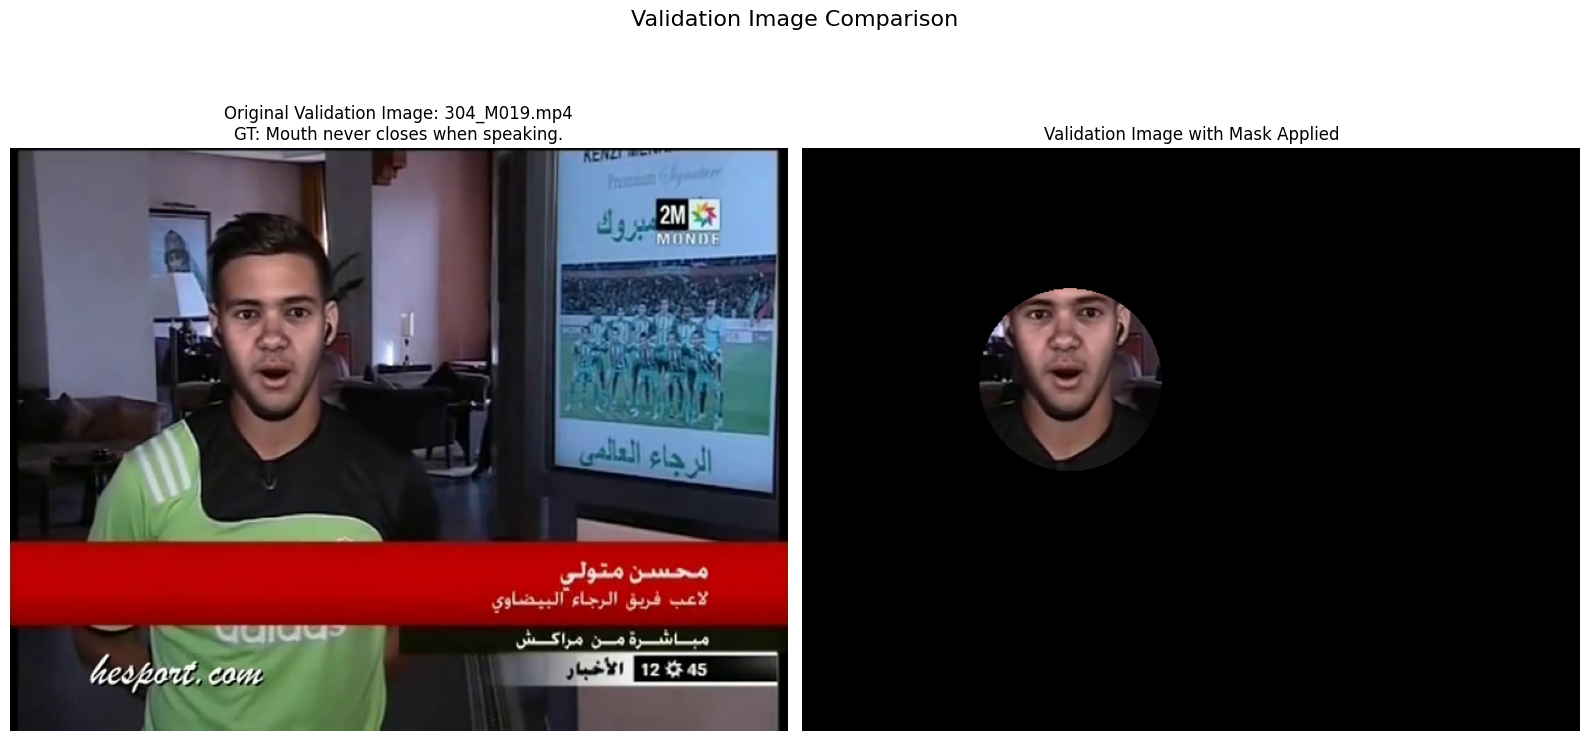

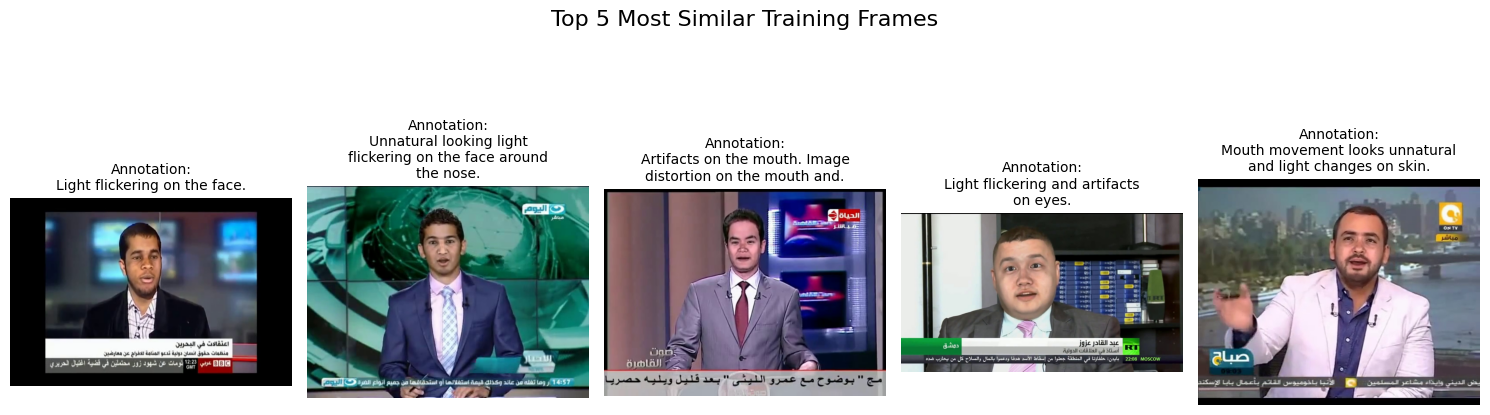

LLaVA Prediction for the Validation Frame:
The image shows a man with a surprised expression on his face, and there are some inconsistencies and artifacts that suggest the possibility of deepfake manipulation. The light flickering on the face and the unnatural looking light flickering around the nose indicate that the image may have been digitally altered. Additionally, the artifacts on the mouth and the unnatural movement of the mouth suggest that the image has been manipulated. The light flickering and artifacts on the eyes also indicate that the image has been digitally altered. Overall, the presence of these inconsistencies and artifacts suggests that the image may have been manipulated using deepfake techniques.


In [1]:
import time
import torch
import sys
sys.path.append('LLaVA')
sys.path.append('C:\\transf\\XAI_DEEPFAKE\\LLaVA')

import pandas as pd
from PIL import Image
import numpy as np
import cv2
from torch.nn.functional import cosine_similarity
from pathlib import Path
import json
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model_frame
from tqdm import tqdm
import clip
import warnings
import os
import matplotlib.pyplot as plt
import textwrap
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MaskUtils:
    @staticmethod
    def apply_mask(frame, keypoint, use_hard_mask=True, radius=75):
        h, w, c = frame.shape
        kp_x = keypoint["x"] * w
        kp_y = keypoint["y"] * h
        yy, xx = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
        distance = np.sqrt((xx - kp_x)**2 + (yy - kp_y)**2)
        mask = (distance <= radius).astype(np.uint8)
        if use_hard_mask:
            for ch in range(c):
                frame[:, :, ch] = frame[:, :, ch] * mask
        else:
            blur_ksize = 83
            dilation_iter = 1
            mask = mask.astype(np.float32)
            blurred = cv2.GaussianBlur(mask, (blur_ksize, blur_ksize), 83)
            blurred_normalized = cv2.normalize(blurred, None, 0, 1, cv2.NORM_MINMAX)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
            dilated = cv2.dilate(blurred_normalized, kernel, iterations=dilation_iter)
            for ch in range(c):
                frame[:, :, ch] = frame[:, :, ch].astype(np.float32) * dilated
            frame = frame.astype(np.uint8)
        return frame

def safe_load_model(model_path, max_retries=3, delay=5):
    attempt = 0
    while attempt < max_retries:
        try:
            tokenizer, llava_model, image_processor, context_len = load_pretrained_model(
                model_path=model_path,
                model_base=None,
                model_name=get_model_name_from_path(model_path)
            )
            return tokenizer, llava_model, image_processor, context_len
        except ZeroDivisionError:
            print(f"ZeroDivisionError during model loading. Retrying... (Attempt {attempt + 1})")
            time.sleep(delay)
            attempt += 1
    raise RuntimeError("Failed to load the model after multiple attempts")

def get_clip_embedding(image, layer="last"):
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    image_tensor = image_tensor.half() if clip_model.visual.conv1.weight.dtype == torch.half else image_tensor
    with torch.no_grad():
        if layer == "first":
            x = clip_model.visual.conv1(image_tensor)
            x = clip_model.visual.bn1(x)
            x = clip_model.visual.relu1(x)
            x = clip_model.visual.conv2(x)
            x = clip_model.visual.bn2(x)
            x = clip_model.visual.relu2(x)
            x = clip_model.visual.conv3(x)
            x = clip_model.visual.bn3(x)
            x = clip_model.visual.relu3(x)
            x = clip_model.visual.avgpool(x)
            embedding = x
        elif layer == "middle":
            x = clip_model.visual.conv1(image_tensor)
            x = clip_model.visual.bn1(x)
            x = clip_model.visual.relu1(x)
            x = clip_model.visual.conv2(x)
            x = clip_model.visual.bn2(x)
            x = clip_model.visual.relu2(x)
            x = clip_model.visual.conv3(x)
            x = clip_model.visual.bn3(x)
            x = clip_model.visual.relu3(x)
            x = clip_model.visual.avgpool(x)
            x = clip_model.visual.layer1(x)
            x = clip_model.visual.layer2(x)
            x = clip_model.visual.layer3(x)
            embedding = x
        elif layer == "last":
            embedding = clip_model.encode_image(image_tensor)
        else:
            raise ValueError("Invalid layer specified. Choose from 'first', 'middle', or 'last'.")
        embedding = embedding.view(embedding.size(0), -1)
    return embedding

def create_custom_prompt(annotations, prompt_version=1):
    if prompt_version == 1:
        base_prompt = (
            "Based on the following descriptions: {annotations}, analyze the face in the image and "
            "identify any signs of deepfake artifacts. Consider how the descriptions might relate to "
            "potential manipulations. Look for abnormalities such as inconsistent lighting, unnatural "
            "facial movements, blurriness around the edges, strange reflections in the eyes, mismatched "
            "facial features, or any other indications of digital manipulation. Provide a detailed "
            "description of any anomalies found."
        )
    if prompt_version == 2:
        base_prompt = (
            "Analyze the face in the image based on the description: '{annotations}'. Identify any "
            "deepfake artifacts, focusing specifically on the affected parts of the face mentioned. "
            "Provide a short and direct explanation highlighting the inconsistencies or manipulations."
        )
    if prompt_version == 3:
        base_prompt = (
            "Based on the following annotations: {annotations}, examine the face in the image for any signs of deepfake manipulation. "
            "Note that the annotations highlight possible alterations, but there may be additional anomalies not captured by them. "
            "Provide a short, concise and objective analysis identifying any inconsistencies, artifacts, or unusual features that could indicate digital manipulation."
        )
    return base_prompt.format(annotations=', '.join(f'"{ann}"' for ann in annotations))

def detect_deepfake(frame, custom_prompt):
    if isinstance(frame, np.ndarray):
        frame = frame.astype('uint8')
    else:
        raise ValueError("Invalid frame data. Expected a NumPy array.")
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(frame_rgb)
    local_args = type('Args', (), {
        "model_path": model_path,
        "model_base": None,
        "model_name": get_model_name_from_path(model_path),
        "query": custom_prompt,
        "conv_mode": None,
        "temperature": 0,
        "top_p": None,
        "num_beams": 1,
        "max_new_tokens": 512,
    })()
    predicted_sentence = eval_model_frame(
        local_args,
        image_pil,
        tokenizer=tokenizer,
        model=llava_model,
        image_processor=image_processor
    )
    return predicted_sentence

def get_training_frames(df):
    training_frames = {}
    for idx, row in df.iterrows():
        video_name = row['movie_name']
        manipulation_path = Path('C:/transf/XAI_DEEPFAKE/LLaVA') / row['manipulation']
        video_path = (manipulation_path / video_name).resolve()
        click_locations = row['click_locations']
        if not click_locations or pd.isna(click_locations):
            continue
        try:
            frame_data = json.loads(click_locations)
            for frame_str, _ in frame_data.items():
                if frame_str.isdigit():
                    frame_num = int(frame_str) - 1
                    if video_path not in training_frames:
                        training_frames[video_path] = []
                    training_frames[video_path].append((frame_num, row['text']))
        except:
            continue
    for video_path, frames in training_frames.items():
        training_frames[video_path] = sorted(frames, key=lambda x: x[0])
    return training_frames

def get_validation_frames(df, num_files=0):
    frames_dict = {}
    total_rows = len(df)
    if num_files > 0:
        total_rows = min(total_rows, num_files)
    for idx, row in df.iterrows():
        if num_files > 0 and idx >= num_files:
            break
        video_name = row['movie_name']
        manipulation_path = Path('C:/transf/XAI_DEEPFAKE/LLaVA') / row['manipulation']
        video_path = (manipulation_path / video_name).resolve()
        click_locations = row['click_locations']
        if not click_locations or pd.isna(click_locations):
            continue
        try:
            frame_data = json.loads(click_locations)
            if video_path not in frames_dict:
                frames_dict[video_path] = {}
            for frame_str, kpt_info in frame_data.items():
                if frame_str.isdigit():
                    frame_num = int(frame_str) - 1
                    if frame_num not in frames_dict[video_path]:
                        frames_dict[video_path][frame_num] = []
                    if isinstance(kpt_info, dict):
                        frames_dict[video_path][frame_num].append(kpt_info)
                    elif isinstance(kpt_info, list):
                        frames_dict[video_path][frame_num].extend(kpt_info)
        except:
            continue
    final_frames = {}
    for video_path, frame_map in frames_dict.items():
        final_frames[video_path] = sorted(
            [(fnum, kpts) for fnum, kpts in frame_map.items()],
            key=lambda x: x[0]
        )
    return final_frames

def run_pipeline(rn_model_name, extraction_layer, top_k, num_files=0, mask_on=False, use_hard_mask=True, prompt_version=1):
    global clip_model, preprocess
    print(f"\nLoading CLIP model {rn_model_name} on {device} ...")
    clip_model, preprocess = clip.load(rn_model_name, device=device)
    clip_model.eval()
    train_frames = get_training_frames(train_df)
    val_frames = get_validation_frames(val_df, num_files)
    emb_save_path = f"training_embeddings_{rn_model_name}_{extraction_layer}.pt"
    if os.path.exists(emb_save_path):
        print(f"Loading cached training embeddings from {emb_save_path} ...")
        emb_data = torch.load(emb_save_path)
        training_embeddings_tensor = emb_data['embeddings']
        training_annotations = emb_data['annotations']
        training_keys = emb_data['keys']
    else:
        print(f"Computing training embeddings for [{rn_model_name}, {extraction_layer}] ...")
        training_embeddings_list = []
        training_annotations = []
        training_keys = []
        for video_path, frames in tqdm(train_frames.items(), desc=f"Processing training videos [{rn_model_name}, {extraction_layer}]"):
            cap = cv2.VideoCapture(str(video_path))
            if not cap.isOpened():
                continue
            for (frame_number, annotation) in frames:
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
                ret, frame = cap.read()
                if not ret:
                    continue
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image_pil = Image.fromarray(frame_rgb)
                embedding = get_clip_embedding(image_pil, layer=extraction_layer)
                training_embeddings_list.append(embedding)
                training_annotations.append(annotation)
                training_keys.append((video_path, frame_number))
            cap.release()
        if len(training_embeddings_list) == 0:
            raise RuntimeError("No training embeddings computed.")
        training_embeddings_tensor = torch.cat(training_embeddings_list, dim=0)
        torch.save({
            'embeddings': training_embeddings_tensor,
            'annotations': training_annotations,
            'keys': training_keys
        }, emb_save_path)
        print(f"Saved training embeddings to {emb_save_path}")
    results = []
    for video_path, frame_info_list in tqdm(val_frames.items(), desc=f"Analyzing validation videos [{rn_model_name}, {extraction_layer}, top_k={top_k}]"):
        cap = cv2.VideoCapture(str(video_path))
        if not cap.isOpened():
            continue
        for (frame_number, keypoints) in frame_info_list:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
            ret, frame = cap.read()
            if not ret:
                continue
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image_pil = Image.fromarray(frame_rgb)
            val_embedding = get_clip_embedding(image_pil, layer=extraction_layer)
            sims = cosine_similarity(val_embedding, training_embeddings_tensor).squeeze(0)
            sorted_indices = torch.argsort(sims, descending=True)
            distinct_indices = []
            used_videos = set()
            for idx in sorted_indices.tolist():
                vid_path, _ = training_keys[idx]
                if vid_path not in used_videos:
                    used_videos.add(vid_path)
                    distinct_indices.append(idx)
                if len(distinct_indices) == top_k:
                    break
            chosen_indices = distinct_indices
            chosen_values = sims[chosen_indices]
            chosen_annotations = [training_annotations[i] for i in chosen_indices]
            closest_train_keys = [training_keys[i] for i in chosen_indices]
            custom_prompt = create_custom_prompt(chosen_annotations, prompt_version=prompt_version) if chosen_annotations else "No annotation available"
            frame_for_llava = frame.copy()
            if mask_on and keypoints:
                for kp in keypoints:
                    frame_for_llava = MaskUtils.apply_mask(frame_for_llava, kp, use_hard_mask=use_hard_mask, radius=75)
            test_deepfake_analysis = detect_deepfake(frame_for_llava, custom_prompt) if chosen_annotations else "No analysis available"
            results.append({
                'rn_model': rn_model_name,
                'extraction_layer': extraction_layer,
                'top_k': top_k,
                'validation_video': str(video_path),
                'validation_frame': frame_number,
                'validation_keypoints': keypoints,
                'closest_train_annotations': chosen_annotations,
                'closest_train_keys': closest_train_keys,
                'test_deepfake_analysis': test_deepfake_analysis,
                'top_k_similarities': chosen_values.tolist(),
                'prompt_version_used': prompt_version,
            })
        cap.release()
    return results

if __name__ == "__main__":
    model_path = "liuhaotian/llava-v1.5-7b"
    tokenizer, llava_model, image_processor, context_len = safe_load_model(model_path)
    llava_model = llava_model.to(device)
    
    csv_path = r'C:\transf\XAI_DEEPFAKE\dataset.csv'
    df = pd.read_csv(csv_path)
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)
    video_paths = df['movie_name'].unique()
    val_videos = video_paths[:100]
    train_videos = video_paths[100:]
    global train_df, val_df
    train_df = df[df['movie_name'].isin(train_videos)]
    val_df = df[df['movie_name'].isin(val_videos)]
    
    rn_models = ["RN101"]
    extraction_layers = ["last"]
    top_k_values = [5]
    
    all_results = []
    for rn_model_name in rn_models:
        for extraction_layer in extraction_layers:
            for top_k in top_k_values:
                print(f"\n=== Running combination: {rn_model_name}, {extraction_layer} extraction, top_k = {top_k} ===")
                comb_results = run_pipeline(
                    rn_model_name=rn_model_name,
                    extraction_layer=extraction_layer,
                    top_k=top_k,
                    num_files=1,
                    mask_on=True,
                    use_hard_mask=True,
                    prompt_version=3
                )
                comb_csv_path = f"results_{rn_model_name}_{extraction_layer}_k{top_k}.csv"
                pd.DataFrame(comb_results).to_csv(comb_csv_path, index=False)
                print(f"Saved results to {comb_csv_path}")
                all_results.extend(comb_results)
    
    combined_csv_path = "results_all_combinations.csv"
    pd.DataFrame(all_results).to_csv(combined_csv_path, index=False)
    print(f"\nAll results saved to {combined_csv_path}")
    
    result_5 = None
    for r in all_results:
        if r['top_k'] == 5:
            result_5 = r
            break

    if result_5 is not None:
        val_img_path = result_5['validation_video']
        val_frame_num = result_5['validation_frame']
        cap = cv2.VideoCapture(val_img_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, val_frame_num)
        ret, val_frame = cap.read()
        cap.release()
        if ret:
            val_frame_rgb = cv2.cvtColor(val_frame, cv2.COLOR_BGR2RGB)
        else:
            val_frame_rgb = None

        masked_val_image = val_frame.copy()
        keypoints = result_5.get('validation_keypoints', [])
        if keypoints:
            for kp in keypoints:
                masked_val_image = MaskUtils.apply_mask(masked_val_image, kp, use_hard_mask=True, radius=75)
        masked_val_image_rgb = cv2.cvtColor(masked_val_image, cv2.COLOR_BGR2RGB)
        
        movie_name = os.path.basename(val_img_path)
        df_dataset = pd.read_csv(csv_path)
        df_dataset = df_dataset[['movie_name', 'text']].drop_duplicates(subset='movie_name')
        mapping = df_dataset.set_index('movie_name')['text'].to_dict()
        gt_text = mapping.get(movie_name, "No GT")
        
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(val_frame_rgb)
        plt.title(f"Original Validation Image: {movie_name}\nGT: {gt_text}", fontsize=12)
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(masked_val_image_rgb)
        plt.title("Validation Image with Mask Applied", fontsize=12)
        plt.axis('off')
        plt.suptitle("Validation Image Comparison", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()
        
        train_keys = result_5.get('closest_train_keys', [])
        train_annotations = result_5.get('closest_train_annotations', [])
        n = len(train_keys)
        plt.figure(figsize=(15, 5))
        for i, key in enumerate(train_keys):
            train_img_path, train_frame_num = key
            cap = cv2.VideoCapture(str(train_img_path))
            cap.set(cv2.CAP_PROP_POS_FRAMES, train_frame_num)
            ret, train_frame = cap.read()
            cap.release()
            if ret:
                train_frame_rgb = cv2.cvtColor(train_frame, cv2.COLOR_BGR2RGB)
            else:
                train_frame_rgb = None
            wrapped_annotation = textwrap.fill(train_annotations[i], width=30)
            plt.subplot(1, n, i+1)
            plt.imshow(train_frame_rgb)
            plt.title(f"Annotation:\n{wrapped_annotation}", fontsize=10)
            plt.axis('off')
        plt.suptitle("Top 5 Most Similar Training Frames", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.90])
        plt.show()
        
        print("LLaVA Prediction for the Validation Frame:")
        print(result_5['test_deepfake_analysis'])
    else:
        print("No result with top_k == 5 found.")


## old

In [2]:
import pandas as pd
import os

dataset_path = r'C:\transf\XAI_DEEPFAKE\dataset.csv'
similarity_results_path = r'C:\transf\XAI_DEEPFAKE\LLaVA\llava\similarity_results_clip_first_resnet101.csv'

video_annotations = pd.read_csv(dataset_path)
similarity_results = pd.read_csv(similarity_results_path)

video_annotations = video_annotations[['movie_name', 'text']]

# Remove duplicates to ensure unique movie_name for mapping
unique_video_annotations = video_annotations.drop_duplicates(subset='movie_name')

# Extract movie names from validation_video paths in the second dataset
similarity_results['movie_name'] = similarity_results['validation_video'].apply(lambda x: os.path.basename(x))

# Map the GT column using the unique video annotations
similarity_results['GT'] = similarity_results['movie_name'].map(
    unique_video_annotations.set_index('movie_name')['text']
)

output_path = r'C:\transf\XAI_DEEPFAKE\LLaVA\llava\similarity_results_clip_first_resnet101_merged.csv'
similarity_results.to_csv(output_path, index=False)

print(f"Updated dataset with GT column saved to {output_path}")


Updated dataset with GT column saved to C:\transf\XAI_DEEPFAKE\LLaVA\llava\similarity_results_clip_first_resnet101_merged.csv


In [3]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

file_path = r'C:\transf\XAI_DEEPFAKE\LLaVA\llava\similarity_results_clip_first_resnet101_merged.csv'
df = pd.read_csv(file_path)

# Group data by validation video ID
video_groups = df.groupby('validation_video')

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Load pre-trained Sentence BERT model
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to get BERT embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Use the average of token embeddings (excluding padding tokens) for the embedding
    token_embeddings = outputs.last_hidden_state  # Shape: (batch_size, seq_length, hidden_size)
    attention_mask = inputs['attention_mask'].unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
    masked_embeddings = token_embeddings * attention_mask
    sum_embeddings = masked_embeddings.sum(dim=1)  # Shape: (batch_size, hidden_size)
    valid_token_count = attention_mask.sum(dim=1)  # Shape: (batch_size, 1)
    average_embedding = sum_embeddings / valid_token_count  # Shape: (batch_size, hidden_size)
    return average_embedding.squeeze(0).numpy()

# Function to get Sentence BERT embeddings
def get_sbert_embedding(texts):
    return sentence_model.encode(texts, convert_to_tensor=True)

# Function to calculate cosine similarity between embeddings
def calculate_cosine_similarity(embedding1, embedding2):
    return cosine_similarity(embedding1, embedding2)[0][0]

# Function to calculate average cosine similarity per video
def calculate_average_cosine_similarity(group, embed_func):
    test_texts = group['test_deepfake_analysis'].astype(str).tolist()
    gt_texts = group['GT'].astype(str).tolist()
    
    if not test_texts or not gt_texts:
        return 0.0
    
    test_embeddings = [embed_func(text) for text in test_texts]
    gt_embeddings = [embed_func(text) for text in gt_texts]
    
    # Calculate cosine similarities for each pair of test and ground truth text
    cosine_similarities = [
        calculate_cosine_similarity(test_emb.reshape(1, -1), gt_emb.reshape(1, -1))
        for test_emb, gt_emb in zip(test_embeddings, gt_embeddings)
    ]
    
    # Return the average cosine similarity for the video group
    return sum(cosine_similarities) / len(cosine_similarities) if cosine_similarities else 0.0

# Calculate average cosine similarity per video using BERT
bert_similarities = [
    calculate_average_cosine_similarity(group, get_bert_embedding)
    for _, group in video_groups
]
average_cosine_similarity_bert = sum(bert_similarities) / len(bert_similarities) if bert_similarities else 0.0
print(f'Average Cosine Similarity (BERT): {average_cosine_similarity_bert}')

# Calculate average cosine similarity per video using Sentence BERT
sbert_similarities = []
for _, group in video_groups:
    test_texts = group['test_deepfake_analysis'].astype(str).tolist()
    gt_texts = group['GT'].astype(str).tolist()
    
    if not test_texts or not gt_texts:
        sbert_similarities.append(0.0)
        continue
    
    # Get embeddings for both columns using Sentence BERT
    test_embeddings_sbert = get_sbert_embedding(test_texts)
    gt_embeddings_sbert = get_sbert_embedding(gt_texts)
    
    # Calculate cosine similarities for each pair of test and ground truth text
    cosine_similarities_sbert = [
        calculate_cosine_similarity(test_emb.cpu().unsqueeze(0).numpy(), gt_emb.cpu().unsqueeze(0).numpy())
        for test_emb, gt_emb in zip(test_embeddings_sbert, gt_embeddings_sbert)
    ]
    
    sbert_similarities.append(sum(cosine_similarities_sbert) / len(cosine_similarities_sbert) if cosine_similarities_sbert else 0.0)

average_cosine_similarity_sbert = sum(sbert_similarities) / len(sbert_similarities) if sbert_similarities else 0.0
print(f'Average Cosine Similarity (Sentence BERT): {average_cosine_similarity_sbert}')


Average Cosine Similarity (BERT): 0.6104885384598824
Average Cosine Similarity (Sentence BERT): 0.3906248190890642


Vlad's method

In [4]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
from scipy.spatial import distance

# Load the CSV data
file_path = r'C:\transf\XAI_DEEPFAKE\LLaVA\llava\similarity_results_clip_first_resnet101_merged.csv'
df = pd.read_csv(file_path)

# Group data by validation video ID
video_groups = df.groupby('validation_video')

# Load pre-trained Sentence BERT model
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to get Sentence BERT embeddings
def get_sbert_embedding(texts):
    return [sentence_model.encode(text, show_progress_bar=False, convert_to_tensor=False) for text in texts]

# Function to calculate cosine similarity between embeddings
def cosine_similarity(y_true, y_pred):
    return 1 - distance.cosine(y_true, y_pred)

# Calculate cosine similarity per frame and average per video using Sentence BERT
sbert_similarities = []
for video_id, group in video_groups:
    test_texts = group['test_deepfake_analysis'].astype(str).tolist()
    gt_texts = group['GT'].astype(str).tolist()
    
    # Handle empty or missing values
    if not test_texts or not gt_texts:
        sbert_similarities.append((video_id, 0.0))
        continue
    
    # Get embeddings for both columns using Sentence BERT
    test_embeddings_sbert = get_sbert_embedding(test_texts)
    gt_embeddings_sbert = get_sbert_embedding(gt_texts)
    
    # Calculate cosine similarities for each frame
    frame_similarities = [
        cosine_similarity(test_emb, gt_emb)
        for test_emb, gt_emb in zip(test_embeddings_sbert, gt_embeddings_sbert)
    ]
    
    # Calculate average cosine similarity for the video group
    avg_cosine_similarity = sum(frame_similarities) / len(frame_similarities) if frame_similarities else 0.0
    sbert_similarities.append((video_id, avg_cosine_similarity))

# Print average cosine similarity per video
for video_id, similarity in sbert_similarities:
    print(f'Video ID: {video_id}, Average Cosine Similarity (Sentence BERT): {similarity}')

# Calculate overall average cosine similarity
average_cosine_similarity_sbert = sum(similarity for _, similarity in sbert_similarities) / len(sbert_similarities) if sbert_similarities else 0.0
print(f'Overall Average Cosine Similarity (Sentence BERT): {average_cosine_similarity_sbert}')


Video ID: C:\transf\XAI_DEEPFAKE\LLaVA\dfdc_train_part_0\nwvloufjty.mp4, Average Cosine Similarity (Sentence BERT): 0.5041042238134934
Video ID: C:\transf\XAI_DEEPFAKE\LLaVA\dfdc_train_part_0\ybefzibreb.mp4, Average Cosine Similarity (Sentence BERT): 0.4646438658237457
Video ID: C:\transf\XAI_DEEPFAKE\LLaVA\dfdc_train_part_2\saokspyemj.mp4, Average Cosine Similarity (Sentence BERT): 0.2826147973537445
Video ID: C:\transf\XAI_DEEPFAKE\LLaVA\dfdc_train_part_2\uqvxjfpwdo.mp4, Average Cosine Similarity (Sentence BERT): 0.5507005055745443
Video ID: C:\transf\XAI_DEEPFAKE\LLaVA\dfdc_train_part_2\yirhsptlko.mp4, Average Cosine Similarity (Sentence BERT): 0.2960479259490967
Video ID: C:\transf\XAI_DEEPFAKE\LLaVA\dfdc_train_part_48\aafuphyhpt.mp4, Average Cosine Similarity (Sentence BERT): 0.5278265216358492
Video ID: C:\transf\XAI_DEEPFAKE\LLaVA\dfdc_train_part_48\alzajhomle.mp4, Average Cosine Similarity (Sentence BERT): 0.3787749111652374
Video ID: C:\transf\XAI_DEEPFAKE\LLaVA\dfdc_train_par

In [5]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
from scipy.spatial import distance

# Load the CSV data
file_path = r'C:\transf\XAI_DEEPFAKE\LLaVA\llava\similarity_results_clip_first_resnet101_merged.csv'
df = pd.read_csv(file_path)

# Group data by validation video ID
video_groups = df.groupby('validation_video')

# Load pre-trained Sentence BERT model
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to get Sentence BERT embeddings
def get_sbert_embedding(texts):
    return [sentence_model.encode(text, show_progress_bar=False, convert_to_tensor=False) for text in texts]

# Function to calculate cosine similarity between embeddings
def cosine_similarity(y_true, y_pred):
    return 1 - distance.cosine(y_true, y_pred)

# Calculate cosine similarity per frame and keep only the highest per video using Sentence BERT
sbert_similarities = []
for video_id, group in video_groups:
    test_texts = group['test_deepfake_analysis'].astype(str).tolist()
    gt_texts = group['GT'].astype(str).tolist()
    
    # Handle empty or missing values
    if not test_texts or not gt_texts:
        sbert_similarities.append((video_id, 0.0))
        continue
    
    # Get embeddings for both columns using Sentence BERT
    test_embeddings_sbert = get_sbert_embedding(test_texts)
    gt_embeddings_sbert = get_sbert_embedding(gt_texts)
    
    # Calculate cosine similarities for each frame
    frame_similarities = [
        cosine_similarity(test_emb, gt_emb)
        for test_emb, gt_emb in zip(test_embeddings_sbert, gt_embeddings_sbert)
    ]
    
    # Keep only the highest cosine similarity for the video group
    max_cosine_similarity = max(frame_similarities) if frame_similarities else 0.0
    sbert_similarities.append((video_id, max_cosine_similarity))

# Print highest cosine similarity per video
for video_id, similarity in sbert_similarities:
    print(f'Video ID: {video_id}, Highest Cosine Similarity (Sentence BERT): {similarity}')

# Calculate overall average of highest cosine similarities
average_cosine_similarity_sbert = sum(similarity for _, similarity in sbert_similarities) / len(sbert_similarities) if sbert_similarities else 0.0
print(f'Overall Average of Highest Cosine Similarities (Sentence BERT): {average_cosine_similarity_sbert}')


Video ID: C:\transf\XAI_DEEPFAKE\LLaVA\dfdc_train_part_0\nwvloufjty.mp4, Highest Cosine Similarity (Sentence BERT): 0.555360727863229
Video ID: C:\transf\XAI_DEEPFAKE\LLaVA\dfdc_train_part_0\ybefzibreb.mp4, Highest Cosine Similarity (Sentence BERT): 0.4646438658237457
Video ID: C:\transf\XAI_DEEPFAKE\LLaVA\dfdc_train_part_2\saokspyemj.mp4, Highest Cosine Similarity (Sentence BERT): 0.2826147973537445
Video ID: C:\transf\XAI_DEEPFAKE\LLaVA\dfdc_train_part_2\uqvxjfpwdo.mp4, Highest Cosine Similarity (Sentence BERT): 0.6050755977630615
Video ID: C:\transf\XAI_DEEPFAKE\LLaVA\dfdc_train_part_2\yirhsptlko.mp4, Highest Cosine Similarity (Sentence BERT): 0.34830328822135925
Video ID: C:\transf\XAI_DEEPFAKE\LLaVA\dfdc_train_part_48\aafuphyhpt.mp4, Highest Cosine Similarity (Sentence BERT): 0.6250597238540649
Video ID: C:\transf\XAI_DEEPFAKE\LLaVA\dfdc_train_part_48\alzajhomle.mp4, Highest Cosine Similarity (Sentence BERT): 0.39397740364074707
Video ID: C:\transf\XAI_DEEPFAKE\LLaVA\dfdc_train_pa